# Генетический алгоритм для предсказания числа бронирования велосипедов на улицах (bikesharing)


*Содиков М. 789 группа ФИВТ МФТИ*

In [0]:
!pip install seaborn # for collab

In [0]:
from google.colab import drive # for collab
drive.mount('/content/drive')

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
%matplotlib inline

In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Для начала загрузим наш датасет 'day.csv', в котором содержатся следующей природы данные:

- instant:              record index
- dteday :              date
- season :              season (1:winter, 2:spring, 3:summer, 4:fall)
- yr :                  year (0: 2011, 1:2012)
- mnth :                month (1 to 12)
- hr :                  hour (0 to 23)
- holiday :             weather day is holiday or not (extracted from [Web Link])
- weekday :             day of the week
- workingday :          if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
-                       1: Clear, Few clouds, Partly cloudy, Partly cloudy
-                       2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
-                       3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered                                                                                                     clouds
-                       4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp :                Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min),                         t_min=-8, t_max=+39 (only in hourly scale)
- atemp:                Normalized feeling temperature in Celsius. The values are derived via (t-                                     t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum:                  Normalized humidity. The values are divided to 100 (max)
- windspeed:            Normalized wind speed. The values are divided to 67 (max)
- casual:               count of casual users
- registered:           count of registered users
- cnt:                  count of total rental bikes including both casual and registered

Будем предсказывать по всем остальным признакам признак cnt. Но для этого отберем нужные признаки с помощью генетического алгоритма. Но для начала расширим наше признаковое пространство

### Изучение данных

Посмотрим что у нас внутри.

In [0]:
df = pd.read_csv('drive/My Drive/MLing/day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


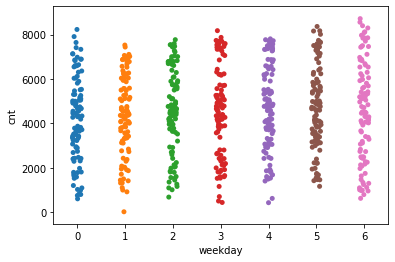

In [0]:
sns.stripplot(x='weekday', y='cnt', data=df)

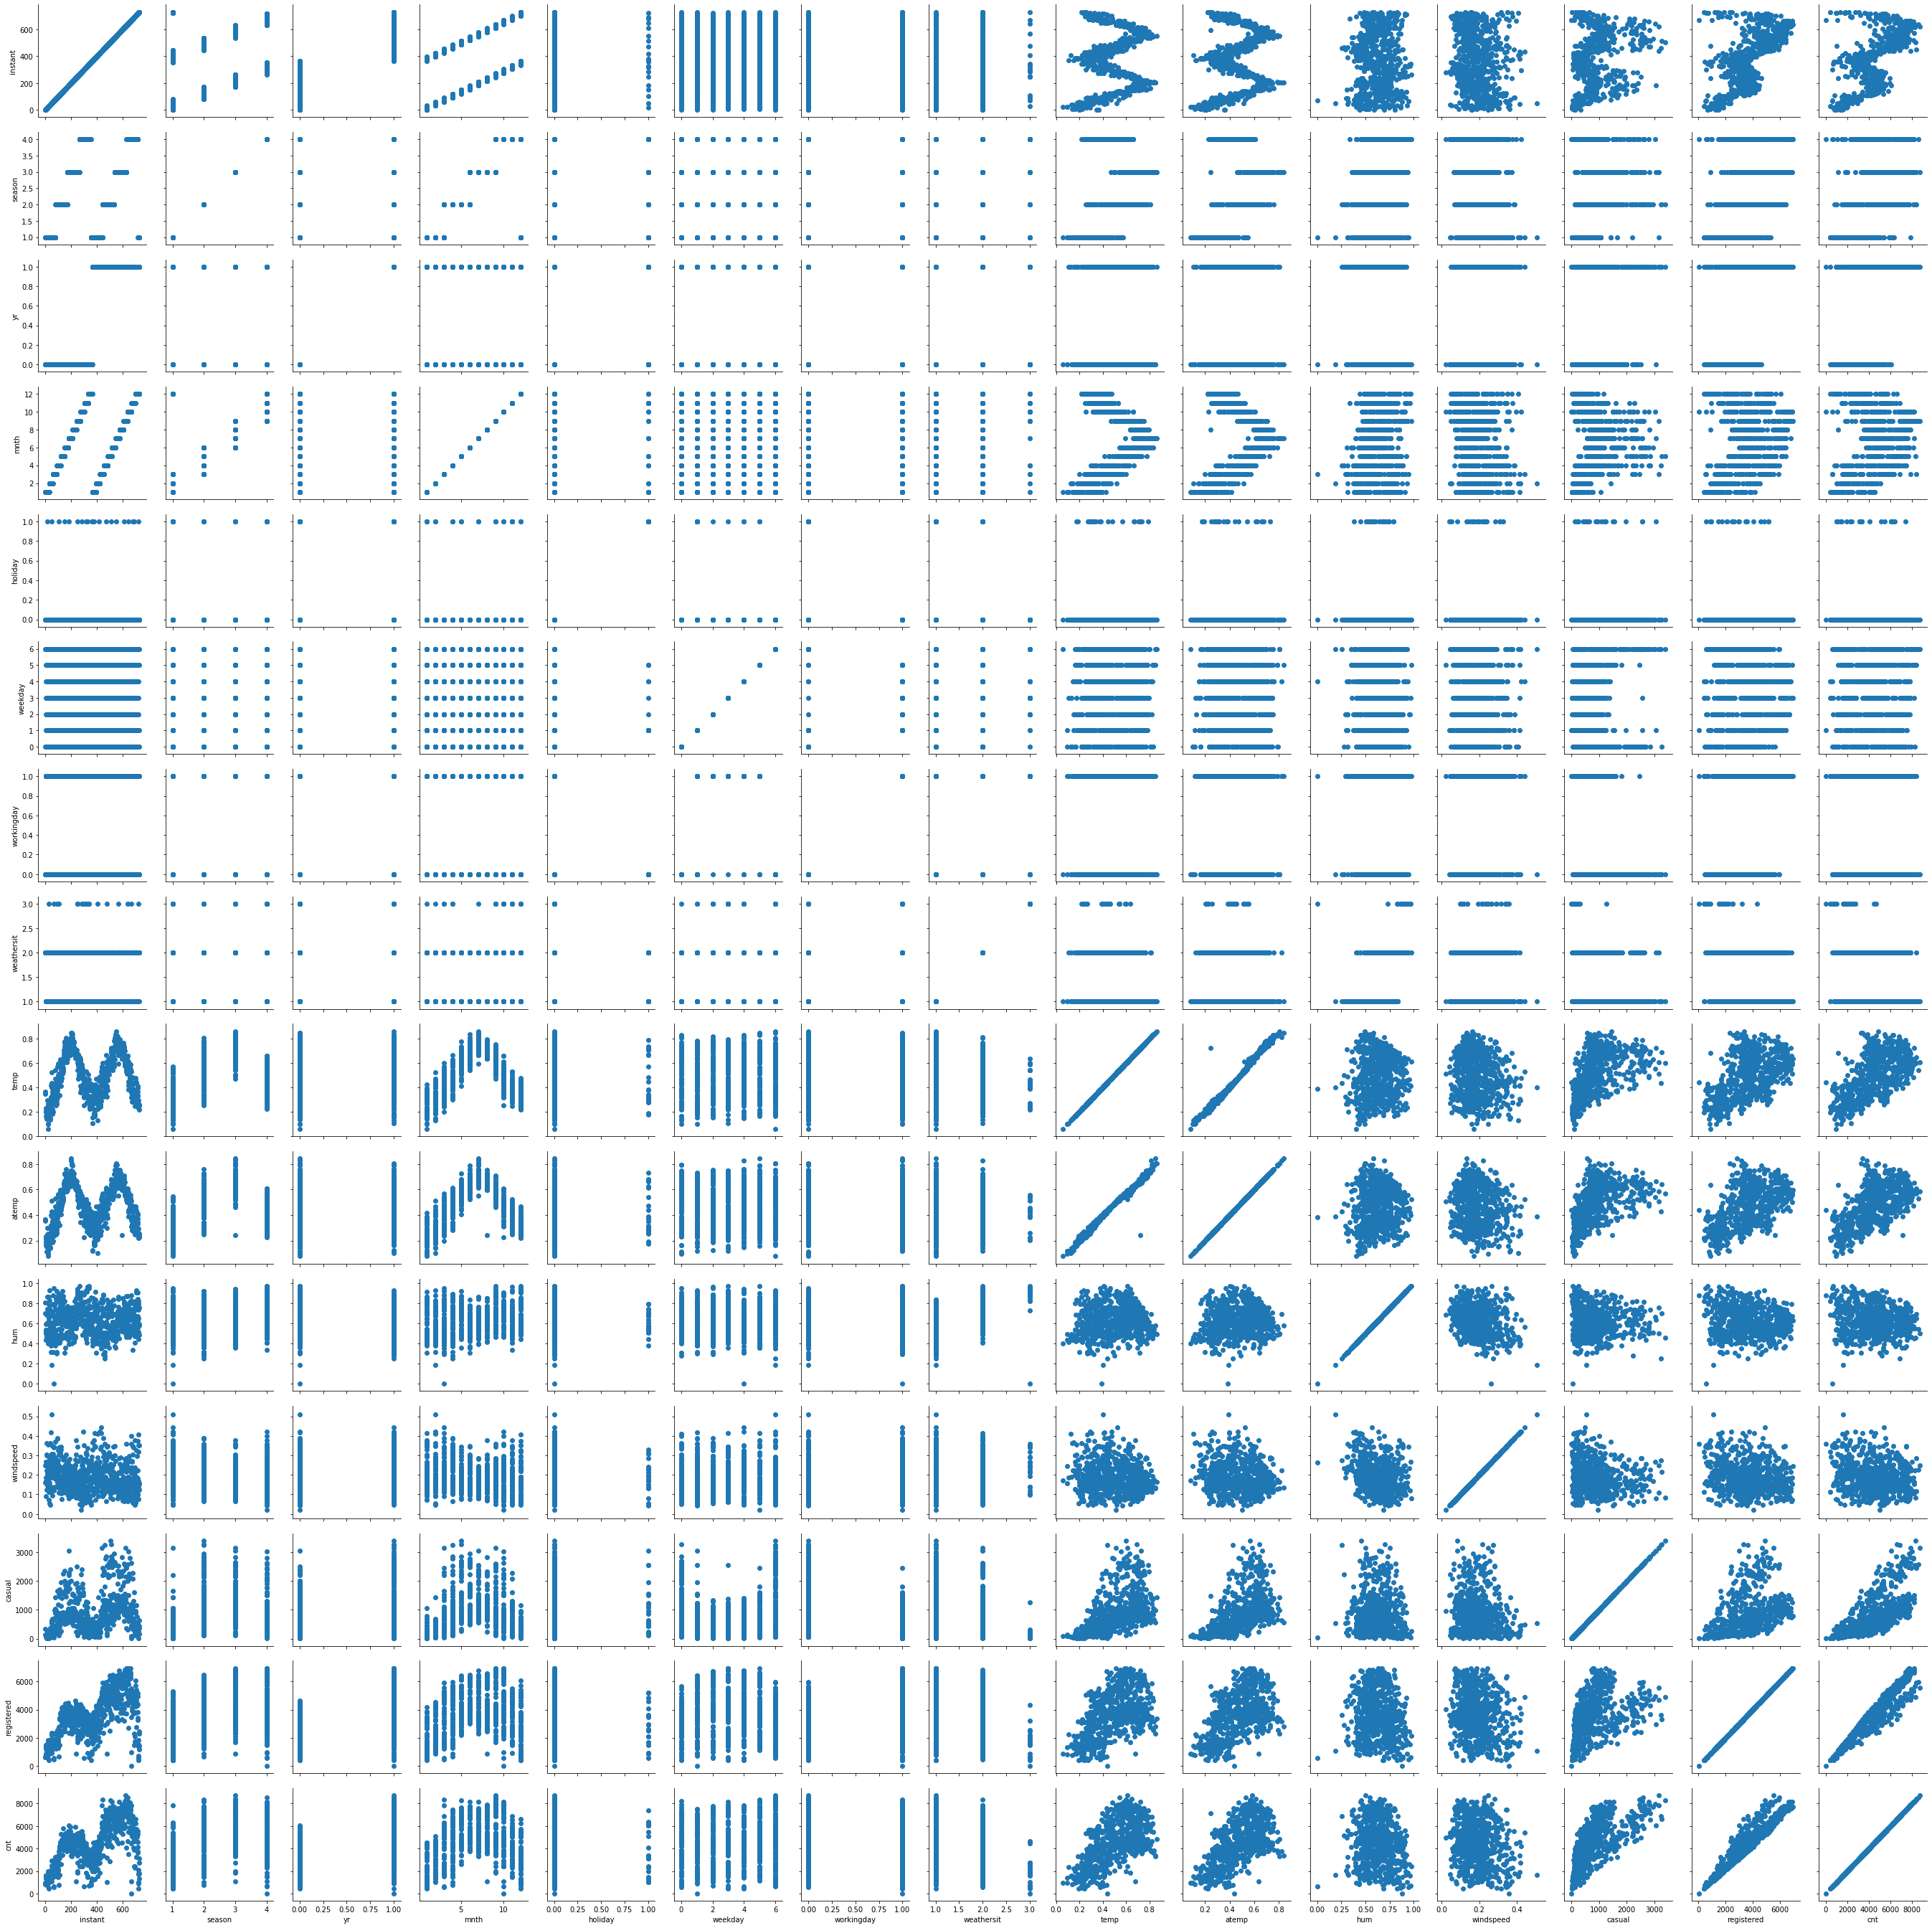

In [0]:
sns.PairGrid(df).map(plt.scatter)

Уже на этом этапе можем заметить некоторые закономерности. Подправим признак даты.

In [476]:
df['timestamp'] = pd.to_datetime(df['dteday']).astype(np.int64)
df['timestamp'] = (df['timestamp'].max()-df['timestamp'])/df['timestamp'].max()
s = list(df['timestamp'].iloc[::-1])
df['timestamp'] = s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Теперь немного помножим наши фичи. 

In [0]:
def generate_features(df, cols):
    for c in cols:
        logc=c+'log' 
        df[logc] = df[c]*(np.log(df[c]))
        df[c+'sqrt'] = df[c]*((df[c])**(1/2))

In [0]:
generate_features(df, ['temp', 'atemp', 'hum', 'windspeed', 'timestamp'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'timestamp', 'templog', 'tempsqrt',
       'atemplog', 'atempsqrt', 'humlog', 'humsqrt', 'windspeedlog',
       'windspeedsqrt', 'timestamplog', 'timestampsqrt'],
      dtype='object')

### Нормализация данных

Нормализуем все данные. Для этого разделим все на значение максимального элемента в каждом столбце, чтобы все значения в таблице были в диапазоне от 0 до 1 включительно.

In [0]:
def normalize(df, cols):
    for col in cols:
        df[col] = df[col]/df[col].max()

Но у нас, как оказалось, все необходимые стоблцы уже отнормированы, а значит нам не обязательно нормировать еще раз, нормализуем только новые появившиеся столбцы.

In [480]:
normalize(df, ['templog', 'tempsqrt', 'atemplog', 'atempsqrt', 'humlog', 'humsqrt',
       'windspeedlog', 'windspeedsqrt'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [481]:
normalize(df, ['timestamplog', 'timestampsqrt'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df = df.dropna()

Так же нужно не упустить "прокравшиеся" незаметно признаки -- это количество зарегистрированных и случайных (новых) клиентов за день. Дело в том, что они напрямую коррелируют с нашим предсказываемым значением общего количества бронирований велосипеда. Конечно, мы можем сделаем multi-variate regression, но кажется, что нас не особо волнует разделение на постоянных и новых клиентов при предсказывании. При анализе данных и спроса -- да, несомненно, но при предсказывании нам достаточно оценить просто количество бронирований общего числа, поэтому попробуем убрать эти две колонки и уже работать с датафреймом без них.



In [483]:
df.drop(columns=['casual','registered'])

KeyError: ignored

Нормализация и предварительная подготовка данных завершена.

In [484]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,timestamp,templog,tempsqrt,atemplog,atempsqrt,humlog,humsqrt,windspeedlog,windspeedsqrt,timestamplog,timestampsqrt
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0.000000,0.999929,0.273973,0.999255,0.272842,0.685568,0.605565,0.940539,0.342756,0.001136,0.000051
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0.000064,0.868868,0.108789,0.856655,0.106899,0.983340,0.301505,0.940294,0.342280,0.002322,0.000143
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0.000127,0.874982,0.111824,0.894087,0.126697,0.845744,0.473068,0.797705,0.177532,0.003526,0.000263
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0.000191,0.914909,0.135178,0.917916,0.142366,0.983489,0.301178,0.852087,0.223515,0.004742,0.000406
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,1606,0.000255,0.882057,0.115491,0.922888,0.146051,0.926059,0.389035,0.587426,0.074149,0.005967,0.000567


### Отбор признаков

Будем использовать генетический алгоритм для отбора признаков. 

In [489]:
df_temp = df.drop(columns='instant')
df_temp.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,timestamp,templog,tempsqrt,atemplog,atempsqrt,humlog,humsqrt,windspeedlog,windspeedsqrt,timestamplog,timestampsqrt
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0.000000,0.999929,0.273973,0.999255,0.272842,0.685568,0.605565,0.940539,0.342756,0.001136,0.000051
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0.000064,0.868868,0.108789,0.856655,0.106899,0.983340,0.301505,0.940294,0.342280,0.002322,0.000143
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0.000127,0.874982,0.111824,0.894087,0.126697,0.845744,0.473068,0.797705,0.177532,0.003526,0.000263
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0.000191,0.914909,0.135178,0.917916,0.142366,0.983489,0.301178,0.852087,0.223515,0.004742,0.000406
5,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,1606,0.000255,0.882057,0.115491,0.922888,0.146051,0.926059,0.389035,0.587426,0.074149,0.005967,0.000567


Будем решать задачу регрессии признака cnt по всем остальным признакам методом наименьших квадратов.


In [0]:
K = 10
TR = 0.8

In [0]:
def get_train_set(df):
    df_train = pd.DataFrame([])
    df_test = pd.DataFrame([])
    num = int(df.shape[0]/K)
    for i in range(num):
        curr_df=df.iloc[K*i:K*i+K]
        size = curr_df.shape[0]
        cut_index = int(TR*size)
        loctrain = curr_df.iloc[:cut_index]
        loctest = curr_df.iloc[cut_index:]
        df_train = df_train.append(loctrain, ignore_index=True)
        df_test = df_test.append(loctest, ignore_index=True)
    return df_test, df_train

In [0]:
df_test, df_train = get_train_set(df_temp)

In [492]:
df_test.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,timestamp,templog,tempsqrt,atemplog,atempsqrt,humlog,humsqrt,windspeedlog,windspeedsqrt,timestamplog,timestampsqrt
0,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,1321,0.000509,0.775562,0.073238,0.775697,0.076010,0.955636,0.349924,0.909982,0.291830,0.010928,0.001369
1,2011-01-11,1,0,1,0,2,1,2,0.169091,0.191464,0.686364,0.122132,1263,0.000573,0.816922,0.086930,0.860341,0.108647,0.702239,0.592922,0.698058,0.118069,0.012179,0.001603
2,2011-01-20,1,0,1,0,4,1,2,0.261667,0.255050,0.538333,0.195904,1927,0.001146,0.953608,0.167346,0.947253,0.167042,0.906314,0.411853,0.868081,0.239860,0.023572,0.004199
3,2011-01-21,1,0,1,0,5,1,1,0.177500,0.157833,0.457083,0.353242,1543,0.001210,0.834131,0.093495,0.792094,0.081317,0.972832,0.322224,0.999198,0.580767,0.024849,0.004535
4,2011-01-30,1,0,1,0,0,0,1,0.216522,0.250322,0.722174,0.073983,1096,0.001783,0.900547,0.125963,0.942425,0.162418,0.639029,0.639924,0.523664,0.055666,0.036413,0.007918


In [488]:
df_train

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,timestamp,templog,tempsqrt,atemplog,atempsqrt,humlog,humsqrt,windspeedlog,windspeedsqrt,timestamplog,timestampsqrt
0,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,86400000000000,2.867344,0.273973,2.522734,0.272842,9.299192,0.605565,4.067415,0.342756,0.001136,0.000051
1,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,172800000000000,2.491521,0.108789,2.162725,0.106899,13.338239,0.301505,4.066354,0.342280,0.002322,0.000143
2,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,259200000000000,2.509053,0.111824,2.257224,0.126697,11.471847,0.473068,3.449721,0.177532,0.003526,0.000263
3,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,345600000000000,2.623546,0.135178,2.317385,0.142366,13.340248,0.301178,3.684899,0.223515,0.004742,0.000406
4,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,1606,432000000000000,2.529342,0.115491,2.329936,0.146051,12.561256,0.389035,2.540357,0.074149,0.005967,0.000567
5,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,1510,518400000000000,2.492293,0.108920,2.244644,0.123767,12.794727,0.367214,3.529483,0.191720,0.007199,0.000745
6,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,959,604800000000000,2.317386,0.083795,2.024985,0.084758,12.328317,0.408987,4.143913,0.381225,0.008437,0.000939
7,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,822,691200000000000,2.132935,0.064325,1.716242,0.051352,13.357623,0.298298,4.323993,0.602374,0.009680,0.001147
8,2011-01-12,1,0,1,0,3,1,1,0.172727,0.160473,0.599545,0.304627,1162,950400000000000,2.364291,0.089749,2.014912,0.083366,11.310336,0.484059,4.256620,0.465100,0.013434,0.001850
9,2011-01-13,1,0,1,0,4,1,1,0.165000,0.150883,0.470417,0.301000,1406,1036800000000000,2.317386,0.083795,1.958305,0.076006,13.081848,0.336426,4.248321,0.456818,0.014693,0.002108


Теперь "вычленим" X и Y для обеих выборок.


In [0]:
X_train = df_train.drop(columns=['cnt','dteday'])
Y_train = df_train['cnt']

X_test = df_test.drop(columns=['cnt','dteday'])
Y_test = df_test['cnt']

Создадим базовые функции для обучения и проверки качества обучения:


In [0]:
def fit(A, y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(A.T, A)), A.T), y)

In [0]:
def MAPE(Y_test, Y_predict):
    mape = ((abs(Y_test-Y_predict)/Y_test).sum())/(Y_test.shape[0]) 
    return mape

Теперь напишем сам алгоритм генетического отбора признаков. 

1) Создадим случайным образом P векторов наших фичей, которые мы "берем" в этот раз;

2) Случайным образом переставим местами половинки двух случайных векторов (скрещивание);

3) Случайным образом поменяем значения в некоторых случайных позициях;

4) Оставим те из моделей, которые лучше всего показали себя после обучения (то есть те, у которых меньше MAPE);

5) Проделаем, пока не достигнем нужной точности предсказания.



In [0]:
def crossing(df, crit):
    models_arr = np.array(df)
    # crossing_index = np.random.randint(1, df.columns.size)
    crossing_index = int(df.columns.size/2)
    matching_set = list(range(df.shape[0]))
    
    while (len(matching_set)):
        # getting random vectors to be crossed
        i = random.choice(matching_set)
        matching_set.remove(i)
        j = random.choice(matching_set)
        matching_set.remove(j)

        # getting crossed vectors
        new1 = np.concatenate((models_arr[j][:crossing_index], models_arr[i][crossing_index:]))
        new2 = np.concatenate((models_arr[i][:crossing_index], models_arr[j][crossing_index:]))
        
        # mutation
        new1 = mutation(new1, crit)
        new2 = mutation(new2, crit)

        # adding to population
        models_arr = np.vstack((models_arr, new1))
        models_arr = np.vstack((models_arr, new2))       

    return pd.DataFrame(models_arr, columns=df.columns)

In [0]:
def mutation(arr, crit):
    # probability of mutation is 20%
    probs_mut = np.random.choice([0, 1], p=[0.9, 0.1], size=crit)

    # choosing |crit| random indexes to be mutated
    indexes_mut = np.random.randint(0, arr.size, size=crit)

    # leave only escaped indexes
    mut_set = probs_mut*indexes_mut

    # randomly add 0 index
    mut_set = mut_set[mut_set != 0]
    if np.random.choice([0, 1], p=[0.8, 0.2]):
        mut_set = np.concatenate((mut_set, [0]))

    # all index from mutation set are mutated
    for i in mut_set:
        arr[i] = 0 if arr[i] else 1
    
    return arr

In [0]:
def get_features_by_mask(columns, mask):
    feat = list(range(len(columns)))*mask
    feat = feat[feat!=0]
    if mask[0]:
        feat = np.concatenate((feat, [0]))
    ret = []
    for e in feat:
        ret.append(columns[e])
    return np.array(ret)

In [0]:
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

In [0]:
def genetic(X_train, X_test, Y_train, Y_test, epochs=40, models_num=20, mut_criteria=20):
    # consts
    cols_list = X_train.columns
    df_models = pd.DataFrame(np.random.randint(0, 
                                               2, 
                                               size=(models_num,
                                                     len(cols_list))),
                             columns=cols_list)
    for epoch in range(epochs):
        # crossing and mutation
        if epoch == 0:
            population = crossing(df_models, mut_criteria)
            population['error'] = 0
        else:
            population = crossing(population, mut_criteria)
            print('EPOCH', epoch, 'min_err =', population['error'].iloc[0])
            
        errs = []
        
        # population evaluation
        for i in range(len(population)):
            # get this model's features
            popval = population.drop(columns=['error'])
            feat = get_features_by_mask(cols_list, np.array(popval.iloc[i]))
            cols_to_del = diff(cols_list, feat)

            # get new X_train
            new_X_train = X_train.drop(columns=cols_to_del)
            new_X_test = X_test.drop(columns=cols_to_del)

            # fit this model
            omegas = fit(new_X_train, Y_train)
            
            # make local prediction on test batch
            Y_predict = np.dot(new_X_test,omegas)

            # calculate its error
            errs.append(MAPE(Y_test, Y_predict))
        
        population['error'] = errs
        population = population.sort_values(by='error').iloc[:20]
    print(population)
    return np.array(population)[0]

In [752]:
best_features = genetic(X_train, X_test, Y_train, Y_test)

EPOCH 1 min_err = 0.14437220501841855
EPOCH 2 min_err = 0.14437220501841855
EPOCH 3 min_err = 0.14437220501841855
EPOCH 4 min_err = 0.1427939637204464
EPOCH 5 min_err = 0.1427939637204464
EPOCH 6 min_err = 0.1427939637204464
EPOCH 7 min_err = 0.1427939637204464
EPOCH 8 min_err = 0.1427939637204464
EPOCH 9 min_err = 0.14236395597290694
EPOCH 10 min_err = 0.14236395597290694
EPOCH 11 min_err = 0.14236395597290694
EPOCH 12 min_err = 0.14236395597290694
EPOCH 13 min_err = 0.14236395597290694
EPOCH 14 min_err = 0.14236395597290694
EPOCH 15 min_err = 0.14236395597290694
EPOCH 16 min_err = 0.14236395597290694
EPOCH 17 min_err = 0.14236395597290694
EPOCH 18 min_err = 0.14236395597290694
EPOCH 19 min_err = 0.14236395597290694
EPOCH 20 min_err = 0.1421689020036516
EPOCH 21 min_err = 0.1421689020036516
EPOCH 22 min_err = 0.1421689020036516
EPOCH 23 min_err = 0.1421689020036516
EPOCH 24 min_err = 0.1421689020036516
EPOCH 25 min_err = 0.1421689020036516
EPOCH 26 min_err = 0.1421689020036516
EPOCH 2

In [0]:
feat = get_features_by_mask(X_train.columns,best_features[:22])

In [0]:
def generate_new_features(df, cols):
    for c in cols:
        df[c+'sqr' ] = df[c]*df[c]
        df[c+'cube'] = df[c]*df[c]*df[c]
        df[c+'exp'] = np.exp(df[c])

In [0]:
generate_new_features(df, ['temp', 'atemp', 'hum', 'windspeed', 'timestamp'])

In [0]:
df_test, df_train = get_train_set(df)

In [0]:
X_train = df_train.drop(columns=['cnt','dteday'])
Y_train = df_train['cnt']

X_test = df_test.drop(columns=['cnt','dteday'])
Y_test = df_test['cnt']

In [784]:
X_train.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,timestamp,templog,tempsqrt,atemplog,atempsqrt,humlog,humsqrt,windspeedlog,windspeedsqrt,timestamplog,timestampsqrt,tempsqr,tempcube,tempexp,atempsqr,atempcube,atempexp,humsqr,humcube,humexp,windspeedsqr,windspeedcube,windspeedexp,timestampsqr,timestampcube,timestampexp
0,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,0.000000,0.999929,0.273973,0.999255,0.272842,0.685568,0.605565,0.940539,0.342756,0.001136,0.000051,0.132116,0.048021,1.438323,0.125131,0.044264,1.424383,0.484537,0.337280,2.005888,0.061772,0.015353,1.282151,0.000000e+00,0.000000e+00,1.000000
1,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,0.000064,0.868868,0.108789,0.856655,0.106899,0.983340,0.301505,0.940294,0.342280,0.002322,0.000143,0.038559,0.007572,1.216970,0.035874,0.006795,1.208530,0.191208,0.083610,1.548479,0.061657,0.015310,1.281856,4.054377e-09,2.581584e-13,1.000064
2,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,0.000127,0.874982,0.111824,0.894087,0.126697,0.845744,0.473068,0.797705,0.177532,0.003526,0.000263,0.040000,0.008000,1.221403,0.044996,0.009545,1.236299,0.348613,0.205834,1.804773,0.025695,0.004119,1.173858,1.621751e-08,2.065267e-12,1.000127
3,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,0.000191,0.914909,0.135178,0.917916,0.142366,0.983489,0.301178,0.852087,0.223515,0.004742,0.000406,0.051509,0.011690,1.254776,0.052565,0.012052,1.257682,0.190931,0.083429,1.547990,0.034932,0.006529,1.205507,3.648939e-08,6.970275e-12,1.000191
4,6,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,0.000255,0.882057,0.115491,0.922888,0.146051,0.926059,0.389035,0.587426,0.074149,0.005967,0.000567,0.041758,0.008533,1.226725,0.054386,0.012683,1.262645,0.268594,0.139202,1.679105,0.008022,0.000718,1.093699,6.487003e-08,1.652213e-11,1.000255


In [786]:
new_best_features = genetic(X_train, X_test, Y_train, Y_test, epochs=100)

EPOCH 1 min_err = 0.12935806251162799
EPOCH 2 min_err = 0.12935806251162799
EPOCH 3 min_err = 0.12675729428309016
EPOCH 4 min_err = 0.12357913862878417
EPOCH 5 min_err = 0.12357913862878417
EPOCH 6 min_err = 0.12357913862878417
EPOCH 7 min_err = 0.12357913862878417
EPOCH 8 min_err = 0.12357913862878417
EPOCH 9 min_err = 0.12345012912448038
EPOCH 10 min_err = 0.12345012912448038
EPOCH 11 min_err = 0.12345012912448038
EPOCH 12 min_err = 0.12050713159561578
EPOCH 13 min_err = 0.1191056186049796
EPOCH 14 min_err = 0.11904309615425289
EPOCH 15 min_err = 0.11694781792296086
EPOCH 16 min_err = 0.11694781792296086
EPOCH 17 min_err = 0.11694781792296086
EPOCH 18 min_err = 0.11694781792296086
EPOCH 19 min_err = 0.11694781792296086
EPOCH 20 min_err = 0.11694781792296086
EPOCH 21 min_err = 0.11694781792296086
EPOCH 22 min_err = 0.11694781792296086
EPOCH 23 min_err = 0.11694781792296086
EPOCH 24 min_err = 0.11694781792296086
EPOCH 25 min_err = 0.11665061949391979
EPOCH 26 min_err = 0.11665061949391

In [0]:
new_feat = get_features_by_mask(X_train.columns, new_best_features[:38])

In [788]:
cols_to_del = diff(X_train.columns, new_feat)
cols_to_del

['instant',
 'weathersit',
 'hum',
 'atempsqrt',
 'humlog',
 'windspeedsqrt',
 'timestamplog',
 'tempexp',
 'atempexp',
 'humsqr',
 'humcube',
 'timestampexp']

In [789]:
new_X_train = X_train.drop(columns=cols_to_del)
new_X_train.shape

(576, 26)

In [0]:
omegas = fit(new_X_train, Y_train)

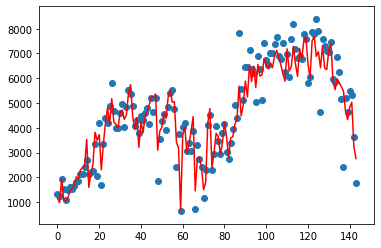

In [791]:
new_X_test = X_test.drop(columns=cols_to_del)
Y_predict = np.dot(new_X_test, omegas)
plt.plot(np.arange(0,144), Y_predict, c='r')
plt.scatter(np.arange(0,144), Y_test)


In [798]:
# напоследок просто посмотрим, что наша модель выдаст в качестве 
# предикшена для случайного дня и сравним с реальным значением

X_sample = new_X_test.iloc[30]
Y_real = Y_test.iloc[30]
omegas = fit(new_X_train, Y_train)
new_X_test = X_test.drop(columns=cols_to_del)
Y_predict = np.dot(X_sample, omegas)
print('For X =', X_sample, 'and Y =', Y_real, 'algorithm gives prediction:', Y_predict)
print()
print('Delay is', abs(Y_real-Y_predict))

For X = season           2.000000
yr               0.000000
mnth             6.000000
holiday          0.000000
weekday          5.000000
workingday       1.000000
temp             0.755000
atemp            0.703292
windspeed        0.140554
timestamp        0.010060
templog          0.576775
tempsqrt         0.820184
atemplog         0.672904
humsqrt          0.490680
windspeedlog     0.749675
timestampsqrt    0.102611
tempsqr          0.570025
tempcube         0.430369
atempsqr         0.494620
atempcube        0.347862
humexp           1.831252
windspeedsqr     0.019755
windspeedcube    0.002777
windspeedexp     1.150911
timestampsqr     0.000101
timestampcube    0.000001
Name: 30, dtype: float64 and Y = 4586 algorithm gives prediction: 4607.255250420935

Delay is 21.255250420935226


Таким образом получили довольно хорошую сходимость и оценку для нашей задачи. Вполне возможно, что "хорошие" фичи на самом деле спрятаны в других закономерностях между признаками, например в нормальной или вейбуллевской декомпозициях от признаков. Но в любом случае, можно с этим поэкспериментировать с помощью процедуры generate_features и аугментировать данные, пока не получим очень точную модель. Так же, я не использовал кросс-валидацию, чтобы упростить вычисления и написание кода, а вместо этого просто разделил на батчи длиной в 10 и каждые 8 объектов из 10 отдавал на трейн, остальные на тест. Таким образом, генетический алгоритм работает быстро и довольно точно при отборе признаков.

Для оценки точности вместо стандартного MSE был использован MAPE, так как является более наглядной мерой для ошибок.

При добавлении нескольких новых (квадрат, куб и экспонента) было получено улучшение на 3%. Таким образом, можно добавляя еще более экзотические зависимости привести нашу модель к еще более совершенной. 

